### **<font color='blue'>Summarizaiton</font>**

In [1]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from langchain_ollama import ChatOllama
from langchain.messages import HumanMessage, AIMessage, RemoveMessage


In [2]:
model = ChatOllama(
    model="qwen3:0.6b",  # gemma3:1b, qwen3:0.6b
    temperature=0.5,
)

model

ChatOllama(model='qwen3:0.6b', temperature=0.5)

In [3]:
class ChatState(MessagesState):
    summary: str


In [4]:
def chat_node(state: ChatState):
    messages = []
    if state["summary"]:
        messages.append({"role": "system", "content": f"Conversation summary: \n{state['summary']}"})
    messages.extend(state["messages"]) # insert a new variable in state name messages
    response = model.invoke(messages)
    return {"messages": [response]}


In [5]:
def summarize_conversation(state: ChatState):
    existing_summary = state['summary']
    if existing_summary:
        prompt = (
            f"Existing summary: \n{existing_summary}\n\n",
            "Extend the summary using the new conversation above."
        )
    else:
        prompt = "summarize the conversation above."

    messages_for_summary = state["messages"] + [HumanMessage(content=prompt)]
    response = model.invoke(messages_for_summary)
    messages_to_delete = state["messages"][:-2]  # Keep last 2 messages

    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in messages_to_delete],
    }



In [6]:
def should_summarize(state: ChatState):
    return len(state["messages"]) > 6


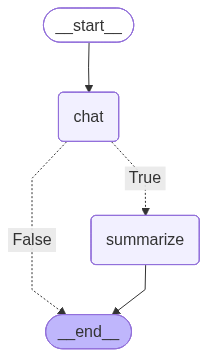

In [7]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "chat")
builder.add_conditional_edges(
    "chat",
    should_summarize,
    {
        True: "summarize",
        False: END
    }
)
builder.add_edge("summarize", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)
graph

In [8]:
config = {"configurable": {"thread_id": "t1"}}

In [9]:
# Gives the current version of the state
def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])


In [10]:
out = graph.invoke({"messages": [HumanMessage(content="Quantum Physics")], "summary": ''}, config=config)
print(out)
show_state()


{'messages': [HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='b28f5657-1be7-462d-93c3-f298f9657579'), AIMessage(content='Quantum physics is a fundamental part of modern physics that deals with the behavior of particles at the smallest scales. Here\'s a concise overview of the key concepts:\n\n1. **Wave-Particle Duality**: At the heart of quantum mechanics is the idea that particles can exhibit both wave-like and particle-like properties. This duality is demonstrated in phenomena like the double-slit experiment, where particles create interference patterns.\n\n2. **Uncertainty Principle**: Formulated by Werner Heisenberg, this principle states that it is impossible to know both the position and momentum of a particle simultaneously. The more precisely one measures one property, the more uncertain the other.\n\n3. **Quantum Entanglement**: When particles (even at large distances) are connected in such a way that their states are correlated, they "s

In [11]:
out = graph.invoke({"messages": [HumanMessage(content="What are some Einstien's famous works.")], "summary": ''}, config=config)
print(out)
show_state()


{'messages': [HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='b28f5657-1be7-462d-93c3-f298f9657579'), AIMessage(content='Quantum physics is a fundamental part of modern physics that deals with the behavior of particles at the smallest scales. Here\'s a concise overview of the key concepts:\n\n1. **Wave-Particle Duality**: At the heart of quantum mechanics is the idea that particles can exhibit both wave-like and particle-like properties. This duality is demonstrated in phenomena like the double-slit experiment, where particles create interference patterns.\n\n2. **Uncertainty Principle**: Formulated by Werner Heisenberg, this principle states that it is impossible to know both the position and momentum of a particle simultaneously. The more precisely one measures one property, the more uncertain the other.\n\n3. **Quantum Entanglement**: When particles (even at large distances) are connected in such a way that their states are correlated, they "s

In [12]:
out = graph.invoke({"messages": [HumanMessage(content="Explain the theory of relativity.")], "summary": ''}, config=config)
print(out)
show_state()


{'messages': [HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='b28f5657-1be7-462d-93c3-f298f9657579'), AIMessage(content='Quantum physics is a fundamental part of modern physics that deals with the behavior of particles at the smallest scales. Here\'s a concise overview of the key concepts:\n\n1. **Wave-Particle Duality**: At the heart of quantum mechanics is the idea that particles can exhibit both wave-like and particle-like properties. This duality is demonstrated in phenomena like the double-slit experiment, where particles create interference patterns.\n\n2. **Uncertainty Principle**: Formulated by Werner Heisenberg, this principle states that it is impossible to know both the position and momentum of a particle simultaneously. The more precisely one measures one property, the more uncertain the other.\n\n3. **Quantum Entanglement**: When particles (even at large distances) are connected in such a way that their states are correlated, they "s

In [13]:
out = graph.invoke({"messages": [HumanMessage(content="Quantum Entanglement")], "summary": ''}, config=config)
print(out)
show_state()


{'messages': [HumanMessage(content='Quantum Entanglement', additional_kwargs={}, response_metadata={}, id='38a439bf-c338-46ea-adea-543c410faf73'), AIMessage(content='**Quantum Entanglement** is a fascinating phenomenon in quantum mechanics where particles, even at large distances, remain connected in a way that their states are correlated. This means that the state of one particle can be "read" by another, even if they are separated by vast distances. Here\'s a concise breakdown:\n\n1. **Definition**:  \n   When particles (like electrons or photons) are connected in such a way that their quantum states are correlated, their properties are "linked." This allows them to be used in quantum computing and information processing.\n\n2. **Example**:  \n   Consider two entangled particles, say electrons, that are created in a superposition of states (e.g., spin-up and spin-down). If one electron is measured, the other’s state is instantly determined, even if they are separated by space. This c

In [14]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Quantum Entanglement', additional_kwargs={}, response_metadata={}, id='38a439bf-c338-46ea-adea-543c410faf73'), AIMessage(content='**Quantum Entanglement** is a fascinating phenomenon in quantum mechanics where particles, even at large distances, remain connected in a way that their states are correlated. This means that the state of one particle can be "read" by another, even if they are separated by vast distances. Here\'s a concise breakdown:\n\n1. **Definition**:  \n   When particles (like electrons or photons) are connected in such a way that their quantum states are correlated, their properties are "linked." This allows them to be used in quantum computing and information processing.\n\n2. **Example**:  \n   Consider two entangled particles, say electrons, that are created in a superposition of states (e.g., spin-up and spin-down). If one electron is measured, the other’s state is instantly determined, even if they are separ